# ДЗ №11. Python для аналитиков ИБ: поиск негативных событий

## Этап 1. Загрузка и подготовка данных

In [ ]:
pip install pandas matplotlib seaborn

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [55]:
def normalize_cell(x):
    if isinstance(x, (list, tuple)):
        x = [str(v) for v in x if v is not None]
        x = [v for v in x if v.strip() not in ("", "-")]

        return x[-1] if x else None
    
    return x

In [56]:
sns.set_theme(style="whitegrid")

PATH = "botsv1.json"

raw = pd.read_json(PATH)
df = pd.json_normalize(raw["result"])

df.head()

,Account_Domain,Account_Name,ComputerName,Creator_Process_ID,EventCode,EventType,Keywords,LogName,Logon_ID,Message,...,ReadData__or_ListDirectory_,Resource_Attributes,Restricted_SID_Count,Transaction_ID,privilege_id,vendor_privilege,QueryName,QueryType,ClientIP,ResponseCode
0,WAYNECORPINC,we3436srv$,we3436srv.waynecorpinc.local,0xddc,4688,0,Audit Success,Security,0x3E7,A new process has been created.\n\nSubject:\n\...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,WAYNECORPINC,we1159srv$,we1159srv.waynecorpinc.local,NaN,4689,0,Audit Success,Security,0x3E7,A process has exited.\n\nSubject:\n\tSecurity ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"[-, WAYNECORPINC]","[-, we9028srv$]",we9028srv.waynecorpinc.local,NaN,4624,0,Audit Success,Security,"[0x0, 0x15D68DA]",An account was successfully logged on.\n\nSubj...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"[WAYNECORPINC, WAYNECORPINC]","[we5878srv$, we5878srv$]",we5878srv.waynecorpinc.local,NaN,4703,0,Audit Success,Security,"[0x3E7, 0x3E7]",A user right was adjusted.\n\nSubject:\n\tSecu...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"[WAYNECORPINC, WAYNECORPINC]","[we3997srv$, we3997srv$]",we3997srv.waynecorpinc.local,NaN,4703,0,Audit Success,Security,"[0x3E7, 0x3E7]",A user right was adjusted.\n\nSubject:\n\tSecu...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
cols_with_lists = [
    c for c in df.select_dtypes(include=["object", "string"]).columns
    if df[c].apply(lambda v: isinstance(v, (list, tuple))).any()
]

df[cols_with_lists] = df[cols_with_lists].apply(lambda col: col.map(normalize_cell))

for col in ["EventCode", "signature_id", "RecordNumber", "event_id", "id"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

df.head()

,Account_Domain,Account_Name,ComputerName,Creator_Process_ID,EventCode,EventType,Keywords,LogName,Logon_ID,Message,...,ReadData__or_ListDirectory_,Resource_Attributes,Restricted_SID_Count,Transaction_ID,privilege_id,vendor_privilege,QueryName,QueryType,ClientIP,ResponseCode
0,WAYNECORPINC,we3436srv$,we3436srv.waynecorpinc.local,0xddc,4688.0,0,Audit Success,Security,0x3E7,A new process has been created.\n\nSubject:\n\...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,WAYNECORPINC,we1159srv$,we1159srv.waynecorpinc.local,NaN,4689.0,0,Audit Success,Security,0x3E7,A process has exited.\n\nSubject:\n\tSecurity ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,WAYNECORPINC,we9028srv$,we9028srv.waynecorpinc.local,NaN,4624.0,0,Audit Success,Security,0x15D68DA,An account was successfully logged on.\n\nSubj...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,WAYNECORPINC,we5878srv$,we5878srv.waynecorpinc.local,NaN,4703.0,0,Audit Success,Security,0x3E7,A user right was adjusted.\n\nSubject:\n\tSecu...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,WAYNECORPINC,we3997srv$,we3997srv.waynecorpinc.local,NaN,4703.0,0,Audit Success,Security,0x3E7,A user right was adjusted.\n\nSubject:\n\tSecu...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Этап 2. Анализ данных

### WinEventLog

In [58]:
def win_suspicious_label(row) -> str | None:
    code = row.get("EventCode")
    cmd = str(row.get("Process_Command_Line") or row.get("CommandLine") or "").lower()
    new_proc = str(row.get("New_Process_Name") or "").lower()
    exit_status = str(row.get("Exit_Status") or "").lower()
    imp_level = str(row.get("Impersonation_Level") or "").lower()
    logon_type = str(row.get("Logon_Type") or "")

    # манипуляция политиками
    if code == 4703:
        return "WinEventLog: 4703 – права/привилегии изменены"

    # создание процесса (подозрительно, если это powershell/cmd/wscript/rundll32 и т.п.)
    if code == 4688:
        if any(x in (cmd + " " + new_proc) for x in ["powershell", "cmd.exe", "wscript", "cscript", "rundll32", "regsvr32"]):
            return "WinEventLog: 4688 – запуск процесса (LOLBIN/скрипты)"

        return "WinEventLog: 4688 – запуск процесса"

    # завершение процесса и ненулевой Exit_Status
    if code == 4689 and exit_status not in ("", "0x0", "0"):
        return "WinEventLog: 4689 – процесс завершился с ошибкой"

    # успешный вход и impersonation/delegation
    if code == 4624 and logon_type == "3" and imp_level in ("impersonation", "delegation"):
        return f"WinEventLog: 4624 – сетевой вход ({imp_level})"

    # доступ к объекту системы
    if code == 4656:
        obj = str(row.get("Object_Name") or "").lower()

        if any(p in obj for p in ["\\windows\\", "\\system32\\", "\\users\\", "\\programdata\\"]):
            return "WinEventLog: 4656 – доступ к объекту (файл/система)"
        
        return "WinEventLog: 4656 – доступ к объекту"

    return None

In [59]:
win = df[df["LogName"].eq("Security")].copy()
win["suspicious_event"] = win.apply(win_suspicious_label, axis=1)
win_susp = win.dropna(subset=["suspicious_event"]).copy()

win_top10 = win_susp["suspicious_event"].value_counts().head(10)
win_top10

suspicious_event
WinEventLog: 4703 – права/привилегии изменены           12
WinEventLog: 4689 – процесс завершился с ошибкой        10
WinEventLog: 4688 – запуск процесса                      8
WinEventLog: 4624 – сетевой вход (impersonation)         2
WinEventLog: 4624 – сетевой вход (delegation)            1
WinEventLog: 4688 – запуск процесса (LOLBIN/скрипты)     1
WinEventLog: 4656 – доступ к объекту (файл/система)      1
Name: count, dtype: int64

### DNS

In [60]:
dns_all = df[(df["LogName"].eq("DNS")) | (df.get("app","").eq("dns"))].copy()

dns_all["dns_target_full"] = (
    dns_all.get("dest_nt_host")
        .fillna(dns_all.get("dest"))
        .fillna(dns_all.get("QueryName"))
        .astype(str)
        .str.lower()
)

dns_top = dns_all["dns_target_full"].value_counts()
dns_top.head(10)

dns_target_full
we3436srv.waynecorpinc.local    1
wkstn01.waynecorpinc.local      1
wkstn02.waynecorpinc.local      1
Name: count, dtype: int64

## Этап 3. Визуализация данных

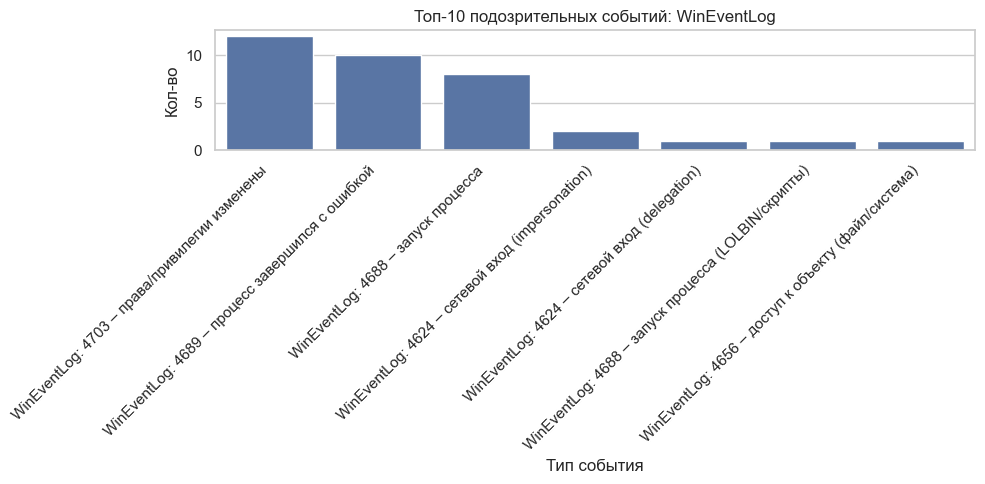

In [61]:
plt.figure(figsize=(10, 5))

ax = sns.barplot(x=win_top10.index, y=win_top10.values)

ax.set_title("Топ-10 подозрительных событий: WinEventLog")
ax.set_xlabel("Тип события")
ax.set_ylabel("Кол-во")

plt.xticks(rotation=45, ha="right")
plt.tight_layout()

plt.show()

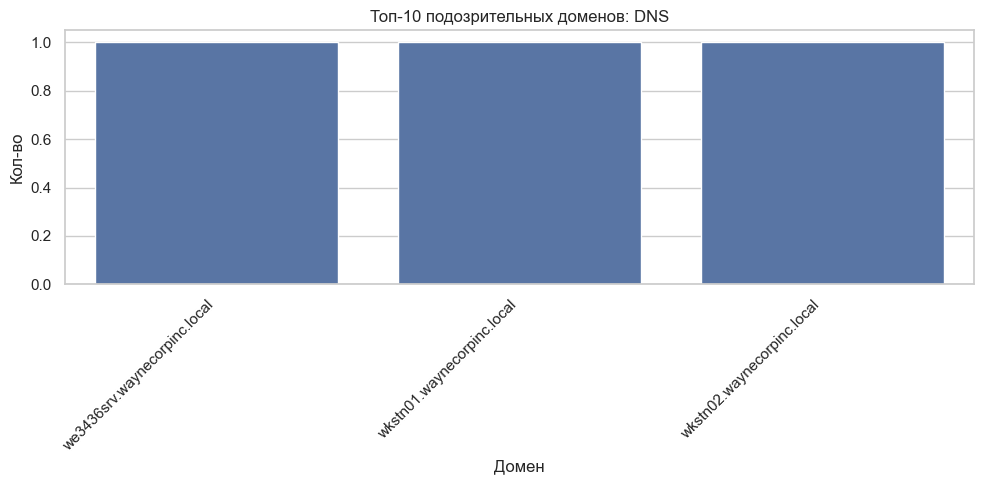

In [62]:
plt.figure(figsize=(10, 5))

ax = sns.barplot(x=dns_top.index, y=dns_top.values)

ax.set_title("Топ-10 подозрительных доменов: DNS")
ax.set_xlabel("Домен")
ax.set_ylabel("Кол-во")

plt.xticks(rotation=45, ha="right")
plt.tight_layout()

plt.show()

## Чек-лист самопроверки
- Установлены библиотеки Pandas, Matplotlib, Seaborn ✓
- Логи WinEventLog и DNS загружены в датафреймы и нормализованы ✓
- Найдены и выделены подозрительные EventID и DNS-запросы ✓
- Построена визуализация топ-10 подозрительных событий с помощью библиотек Seaborn или Matplotlib ✓
- Результат выполнения задания соответствует условиям задания ✓
- На учебной платформе прикреплена ссылка на GitHub-репозиторий с результатами выполнения задания ✓
- Репозиторий по ссылке доступен для просмотра другим пользователям, название репозитория содержит фамилию и имя студента, номер домашнего задания ✓